# Updated FCNs

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv1D, GlobalAveragePooling1D, Dense, Dropout, LeakyReLU
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [4]:

# Load the dataset
file_path = 'C:/Users/dugga/OneDrive/Desktop/ML1/ML/data/AAPL.csv'
data = pd.read_csv(file_path)

# Select the 'Close' column
close_prices = data['Close'].values

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
close_prices_scaled = scaler.fit_transform(close_prices.reshape(-1, 1))

# Create sequences
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Define the sequence length
seq_length = 60

# Create sequences
X, y = create_sequences(close_prices_scaled, seq_length)

# Split the data into training and testing sets
split_ratio = 0.8
split_index = int(len(X) * split_ratio)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]


In [6]:
# Reshape data for Conv1D
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define the optimized FCN model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, input_shape=(seq_length, 1)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.2))
model.add(Conv1D(filters=128, kernel_size=3))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.2))
model.add(Conv1D(filters=64, kernel_size=3))
model.add(LeakyReLU(alpha=0.1))
model.add(GlobalAveragePooling1D())
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# Compile the model with a custom learning rate
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Display the model summary
model.summary()


C:\Users\dugga\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\dugga\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 58, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 58, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 58, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 56, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 56, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 54, 64)              │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 54, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,713 (202.00 KB)

 Trainable params: 51,713 (202.00 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# implementng the early stopping:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# patience=10: This parameter defines how many epochs with no improvement in val_loss should be tolerated before stopping the training.
# In this case, if val_loss does not improve for 10 consecutive epochs, training will be stopped.

# Train the model with early stopping
history = model.fit(
    X_train_reshaped,
    y_train,
    epochs=100,  # Increase epochs, early stopping will prevent overfitting
    batch_size=64,  
    validation_split=0.2,  
    callbacks=[early_stopping] # monitors 'val_loss' and stops training when it's no longer improving
)

Epoch 1/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - loss: 9.0375e-06 - val_loss: 8.6025e-04
Epoch 2/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 5.1024e-07 - val_loss: 7.8933e-04
Epoch 3/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 5.5158e-07 - val_loss: 7.0078e-04
Epoch 4/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 5.7633e-07 - val_loss: 5.3717e-04
Epoch 5/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 4.6526e-07 - val_loss: 4.4676e-04
Epoch 6/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 5.1129e-07 - val_loss: 4.0431e-04
Epoch 7/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 4.4790e-07 - val_loss: 2.8685e-04
Epoch 8/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 3.8309e-07 - val_loss: 3.2238e-04
Epoch 9/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 6.0424e-07 - val_loss: 2.2010e-04
Epoch 10/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 4.9777e-07 - val_loss: 1.7726e-04
Epoch 11/100
104/104 ━━━━━━━━━━━━━━━━━

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.4576e-04
Test Loss: 0.003031547646969557
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
RMSE: 10.018673132957034
MAE: 6.553646481285972
MAPE: 9.18087815032284


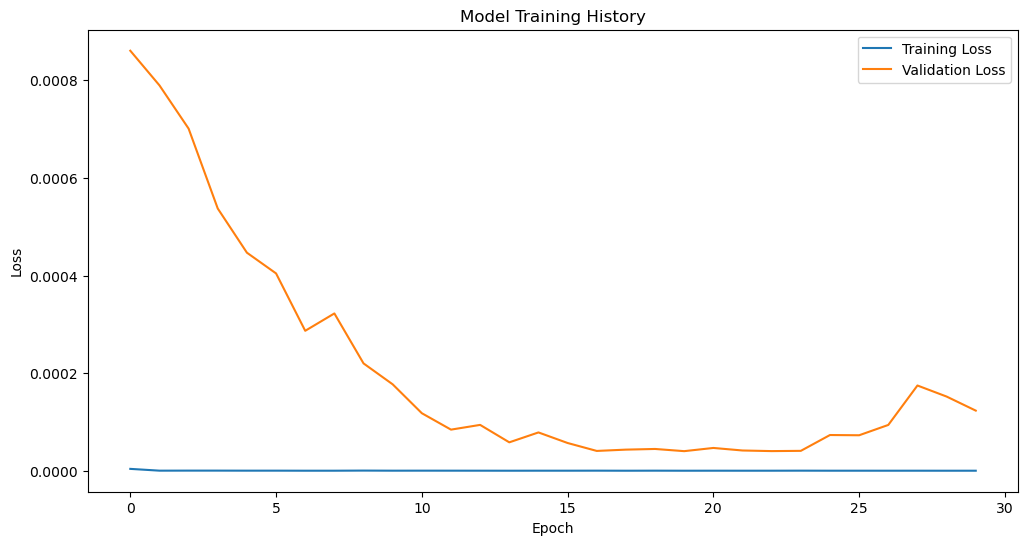

In [10]:
# Evaluate the model on the test set
loss = model.evaluate(X_test_reshaped, y_test)
print(f'Test Loss: {loss}')

# Make predictions
predictions = model.predict(X_test_reshaped)

# Inverse transform the predictions and true values to get the original scale
predictions_inverse = scaler.inverse_transform(predictions)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_inverse, predictions_inverse))
print(f'RMSE: {rmse}')

# Calculate MAE
mae = mean_absolute_error(y_test_inverse, predictions_inverse)
print(f'MAE: {mae}')

# Calculate MAPE
mape = np.mean(np.abs((y_test_inverse - predictions_inverse) / y_test_inverse)) * 100
print(f'MAPE: {mape}')

# Plot the training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


     

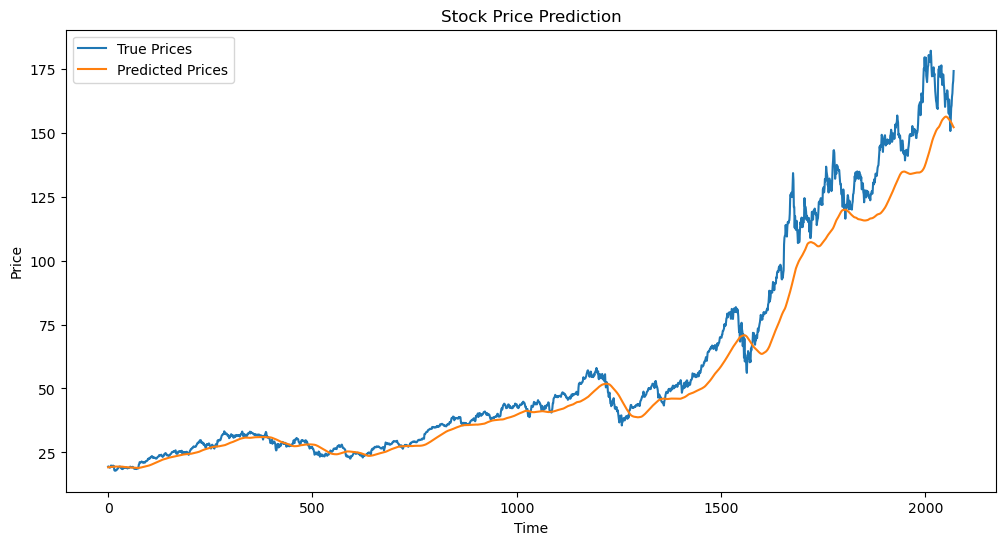

In [12]:
# Plot the predictions against the true values
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='True Prices')
plt.plot(predictions_inverse, label='Predicted Prices')
plt.legend()
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()